<h3>Required libraries for this notebook:</h3>

In [32]:
import pandas as pd
import numpy as np
import datetime as dt

In [33]:
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<h3>General purpose function for later usage for indicators calculations:</h3>
<h4><b>Function to collect Adjusted close price for a particualr stock in a desired given day: </b></h4>

In [3]:
def stock_price(stock, start_date, end_date):
    #df_merged = pd.DataFrame (index = dates) 
    df_temp = yf.download(stock[0] , start=start_date, end=end_date, progress=False)
    df_temp = df_temp. rename ( columns ={'Adj Close':stock[0]})
    df_temp = df_temp.loc [:, stock]
    #df_merged = df_merged.join(df_temp , how ='inner')
    #return df_merged
    return df_temp

#### collect any desired stock price (Adj. close) for any given period of time: 

In [12]:
sd = dt.datetime(2020, 3, 20)
ed = dt.datetime(2022, 5, 20)
syms = ['MSFT']
prices = stock_price(syms, sd, ed)
prices.fillna(method ='ffill',inplace=True)
prices.fillna(method ='bfill',inplace=True)

#### make price normalized: 

In [13]:
prices = prices/prices.iloc[0] # normalise price

<h3 id='bollinger'>Bollinger Band Percentage (a Volatility and Momentum Indicator) </h3>
<p> Developed by John Bollinger, Bollinger Bands are envelopes plotted at two standard deviation levels above and below a Simple Moving Average (SMA) of the price. Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price [3].</p>

<h4><b>Function to get Simple Moving Average (SMA), as it is needed later for bollinger bands calculation: </b></h4>

In [4]:
def get_sma (df, lookback_window=14):
    sma = df.rolling(window=lookback_window,min_periods=lookback_window).mean()
    return sma

<h4><b>Functions for std, upper & lower  bollinger bands, and bollinger band percentage:</b></h4>

In [5]:
##### std:
def get_std(df, lookback_window=14):
    std = df.rolling(window=lookback_window,min_periods=lookback_window).std()
    return std



##### Bollinger Bands and percentage:

# upper bollinger band
def get_bb_up(df,lookback_window=14):
    sma = get_sma(df)
    std = get_std(df)
    bb_up = sma + 2*std
    return bb_up
# lower bollinger band
def get_bb_low(df,lookback_window=14):
    sma = get_sma(df)
    std = get_std(df)
    bb_low = sma - 2*std
    return bb_low
# bollinger band percentage
def get_bbp(df, lookback_window=14):
    sma = get_sma(df)
    std = get_std(df)
    bb_up = get_bb_up(df)
    bb_low = get_bb_low(df)
    bbp = (df - bb_low)/(bb_up-bb_low)
    return bbp

###### Price/SMA
def get_price_sma_ratio (df,lookback_window=14):
    sma = get_sma(df)
    price_sma_ratio = df/sma
    return price_sma_ratio

In [15]:
sma = get_sma(prices)

bbp = get_bbp(prices)
bb_up = get_bb_up(prices)
bb_low = get_bb_low(prices)

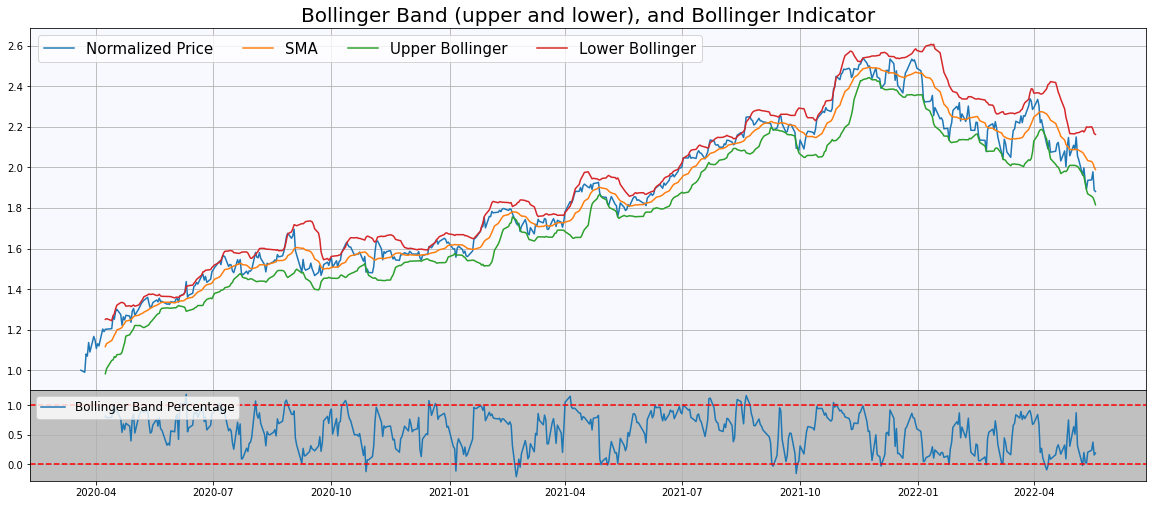

In [16]:
    ###### Plot for Bollinger Bands and Percentage
    fig1 = plt.figure(facecolor='white', figsize=(20, 10))
    #ax = fig.add_subplot(2,1,1)
    ax = plt.subplot2grid((6, 4), (1, 0), rowspan=4, colspan=4)
    plt.plot(prices)
    plt.plot(sma)
    plt.plot(bb_low)
    plt.plot(bb_up)
    plt.grid()


    ax.set_facecolor('ghostwhite')
    ax.legend(['Normalized Price','SMA', 'Upper Bollinger', 'Lower Bollinger'], ncol=4, loc='upper left', fontsize=15)
    plt.title('Bollinger Band (upper and lower), and Bollinger Indicator', fontsize=20)
    #bx = fig.add_subplot(2, 1, 2)

    bx = plt.subplot2grid((6, 4), (5, 0), rowspan=1, colspan=4, sharex=ax)
    plt.plot(bbp)

    plt.legend(['Bollinger Band Percentage'],ncol=3, loc = 'upper left', fontsize = 12)
    bx.set_facecolor('silver')
    plt.subplots_adjust( hspace=0)
    plt.grid()

    plt.axhline(y=0.0,color ="red", linestyle='--')
    plt.axhline(y=1.0,color ="red", linestyle='--')
    plt.savefig("Indicator - Bollinger Bands")

<p> The above Figure represents Bollinger Band and Simple Moving Average (SMA) for 10 days, along with normalized adjusted price for “MSFT”, top plot, and normalized Bollinger percentage, bottom plot.
The Bollinger Bands are widened when volatility has been increased in the past engaged days, and narrows down when volatility is reduced.</p>
<p>The Bollinger percent indicator has been plotted with two horizontal red lines associated with the values equal to 0.0 and 1.0. Those red lines may suggest a Buy or Sell decision. Bollinger percent is above 1 when price is above the upper band and below o when price is below the lower band.</p>
<p>A common approach when using Bollinger Bands is to identify overbought or oversold market conditions. When the price of the asset breaks below the lower band of the Bollinger Bands, prices have perhaps fallen too much and are due to bounce. On the other hand, when price breaks above the upper band, the market is perhaps overbought and due for a pullback [4].</p>
<p><b>Buy Signal:</b> Once the indicator value reaches to 0.0, after it has been below 0.0, price is returning to Bollinger bands and it is a good time to buy.</p>
<p><b>Sell Signal:</b> Once the value touches the 1.0, after it has been above 1.0, it is a good time sell.</p>

<h3 id='ema'>Exponential Weighted Moving Average (EMA): </h3>
<p> The EMA is a moving average that places a greater weight and significance on the most recent data points.</p>
<p>Like all moving averages, this technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical average [5]. In
the below figure, I have displayed short term, engaging 15-days and a long term, 200-days EMA indicators, alongside with the normalized price. A considerable di-vergence between the short and long terms EMA might suggest the signal for buy or sell. To follow this idea, we need to consider a threshold and the buy and sell signal would be then like the followings:</p>


In [17]:
##### Exponentially-weighted Moving Average
def EWMA(data_prices, ndays):
 #EMA = pd.Series(data[syms].ewm(span = ndays, min_periods = ndays - 1).mean(),name = 'EWMA_' + str(ndays))
 #data = data.join(EMA)
 EMA =data_prices.iloc[:,0].ewm(span=ndays, min_periods = ndays - 1, adjust=True).mean()

 return EMA

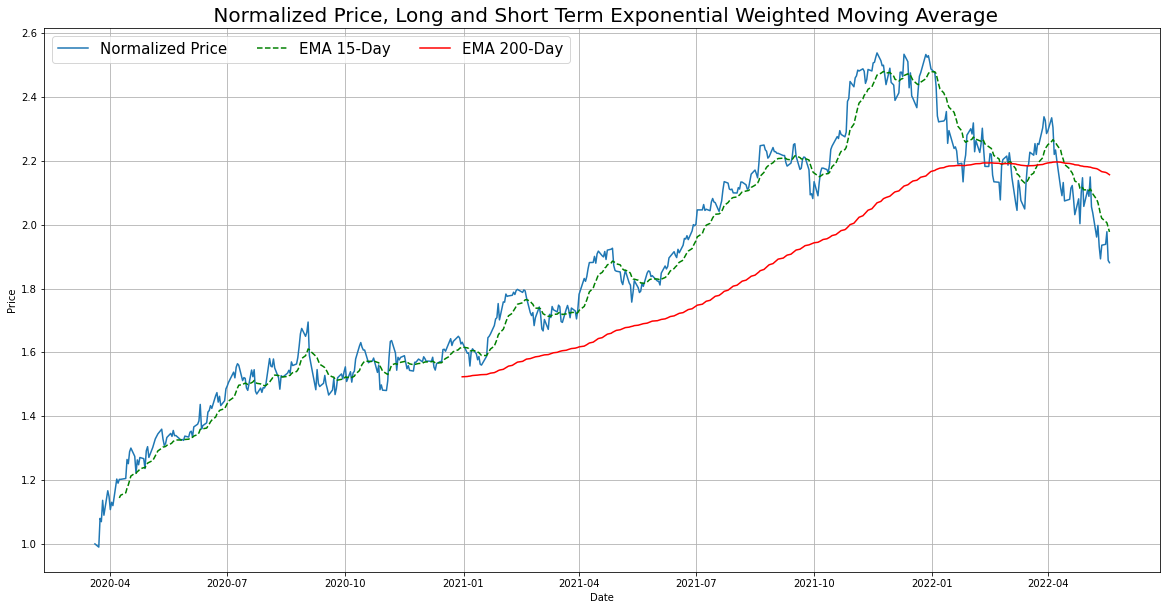

In [30]:
    ###### Plot for Exponential Moving Average
    ema_15 =EWMA(prices, 15)
    ema_200 = EWMA(prices, 200)

    fig2 = plt.figure(figsize=(20, 10))
    plt.plot(prices, label="Price")
    plt.plot(ema_15, label="15-Day EMA", color="green", linestyle='--')
    plt.plot(ema_200, label="200-Day EMA",color ="red")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(['Normalized Price','EMA 15-Day', 'EMA 200-Day'], ncol=3, loc='upper left', fontsize=15)
    plt.title(' Normalized Price, Long and Short Term Exponential Weighted Moving Average', fontsize=20)
    plt.grid()
    plt.savefig("Indicator - EMA")

<p><b>Buy Signal:</b> EMA (Long) – EMA (Short) being greater than the Threshold</p>
<p><b>Sell Signal:</b> EMA (Long) – EMA (Short) being smaller than the Threshold</p>

<a id='momentum'></a>
<h3 >Momentum: </h3>
<p> Momentum is an indicator that reveals the speed of a price movement, and measures the rate of rise or fall of a stock price.</p>
<p>It is calculated as the difference between the most recent price and the closing price of a previously determined period [6].</p><p> &emsp;&emsp; Momentum (n day) = (today price/price n days ago) – 1 </p>

<p>&emsp;&emsp; <b>Buy Signal:</b>when Momentum indicator goes above zero (or a defined level)</p>
<p>&emsp;&emsp; <b>Sell Signal:</b>when Momentum indicator goes below zero (or a defined level)</p>

In [19]:
###### Momentum
def get_momentum(df,lookback_window=14):
    momentum = df/df.shift(lookback_window-1) - 1
    return momentum

<p>
In below figure, I have shown the “MSFT” Normalized price and the 10-Day momen-tum. I have considered two horizontal lines as the guiding levels for assisting the trading. Once momentum goes beyond 0.03, the green dotted line, that should invoke a buying signal, and similarly once the indicator goes below -0.03, the red dotted line, that should trigger a selling signal. Such values are just for demon-stration in this report and need to be adjusted as required.</p>

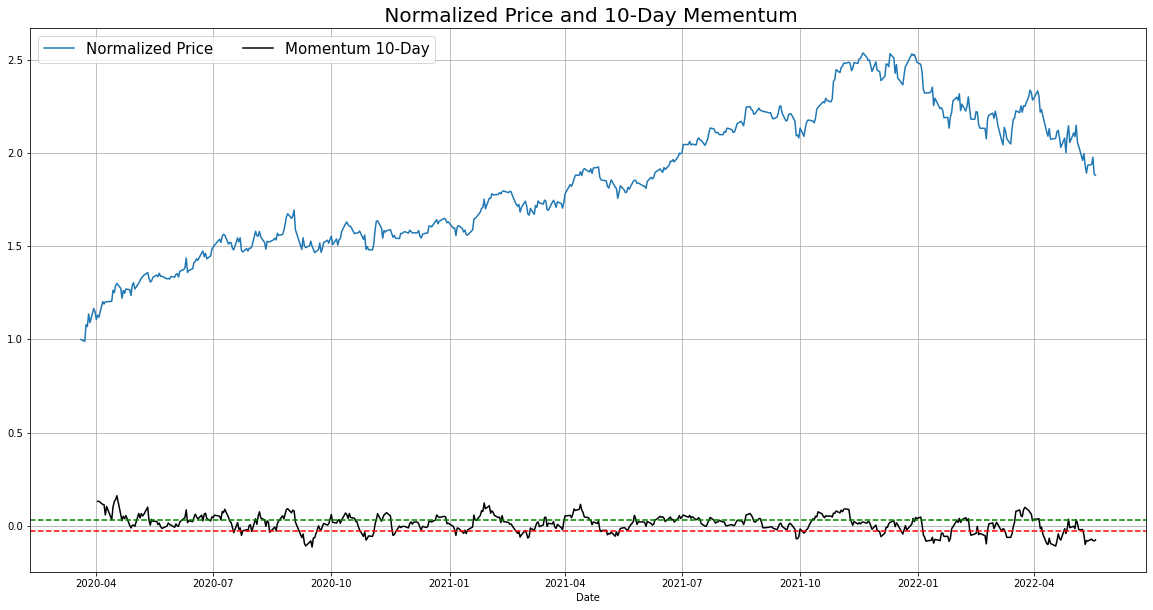

In [20]:
###### Plot for Momentum
momentum_10 = get_momentum(prices, 10)
fig3 = plt.figure(figsize=(20, 10))
plt.plot(prices, label="Price")
plt.plot(momentum_10 , label="10-Day Momentum", color="black")


plt.xlabel("Date")
plt.legend(['Normalized Price','Momentum 10-Day'], ncol=2, loc='upper left', fontsize=15)
plt.axhline(y=0.03, color="green", linestyle='--')
plt.axhline(y=-0.03, color="red", linestyle='--')
plt.title(' Normalized Price and 10-Day Mementum', fontsize=20)
plt.grid()
plt.savefig("Indicator - Momentum")

<h3 id='rsi'>Relative Strength Index (RSI): </h3>
<p> RSI is a momentum indicator, used in technical analysis that measures the mag-nitude of recent price changes to evaluate overbought or oversold conditions [7]. To calculate the RSI, at first the average gain and loss over a lookback period have to be calculated, and then the indicator is calculated using the following formula:</p>
<p> &emsp; &emsp; RSI = 100 - $(\frac{100}{1+ \frac{Average Gain}{ Average Loss}})$</p>
<p>Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be sub-jected for a trend reversal or corrective pullback in price [7], similarly, the RSI value of 30 or below indicates an oversold or undervalued condition.</p>


In [21]:
###### RSI
# the code is taken from the CS7646 (ML4T) course material, titled = CDB.vectorize_me.pptx
def get_RSI(price, lookback):
    daily_rets = price.copy()
    daily_rets.values[1:,:] = price.values[1:,:] - price.values[:-1,:]
    daily_rets.values[0,:] = np.nan

    up_rets = daily_rets[daily_rets >= 0].fillna(0).cumsum()
    down_rets = -1 * daily_rets[daily_rets <0].fillna(0).cumsum()

    up_gain = price.copy()
#     up_gain.ix[:,:] = 0
    up_gain.iloc[:,:] = 0
    up_gain.values[lookback:,:] = up_rets.values[lookback:,:] - up_rets.values[:-lookback,:]

    down_loss = price.copy()
#     down_loss.ix[:,:] = 0
    down_loss.iloc[:,:] = 0
    down_loss.values[lookback:,:] = down_rets.values[lookback:,:] - down_rets.values[:-lookback,:]

    rs = (up_gain / lookback) / (down_loss / lookback)
    rsi = 100 - (100/ (1+rs))
#     rsi.ix[:lookback,:] = np.nan
    rsi.iloc[:lookback,:] = np.nan
    rsi[rsi == np.inf] = 100

    return rsi


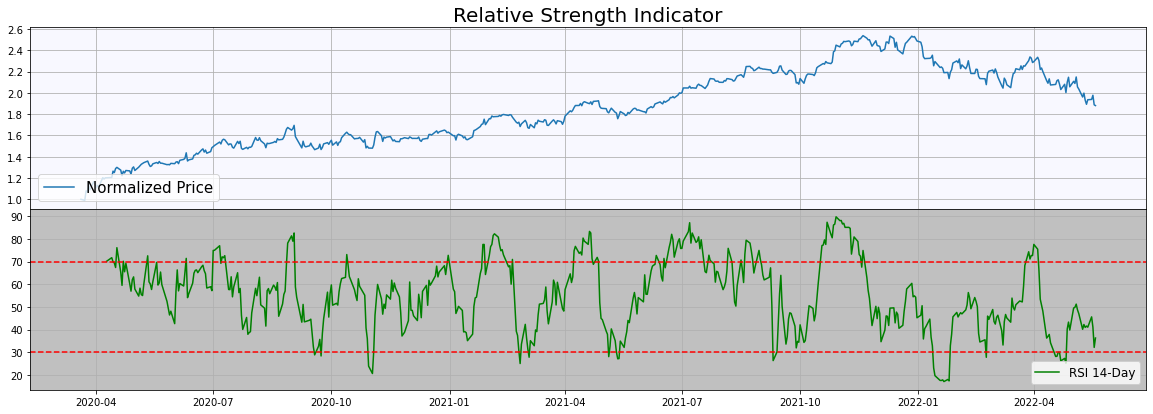

In [128]:
    rsi_14=get_RSI(prices, 14)

    fig4 = plt.figure(facecolor='white', figsize=(20, 10))
    #ax = fig.add_subplot(2,1,1)
    ax = plt.subplot2grid((6, 4), (1, 0), rowspan=2, colspan=4)
    plt.plot(prices)
    plt.grid()

    ax.set_facecolor('ghostwhite')
    ax.legend(['Normalized Price'], ncol=4, loc='lower left', fontsize=15)
    plt.title('Relative Strength Indicator', fontsize=20)
    #bx = fig.add_subplot(2, 1, 2)

    bx = plt.subplot2grid((6, 4), (3, 0), rowspan=2, colspan=4, sharex=ax)
    plt.plot(rsi_14 , color="green")

    plt.legend(['RSI 14-Day'],ncol=3, loc = 'lower right', fontsize = 12)
    bx.set_facecolor('silver')
    plt.subplots_adjust( hspace=0)
    plt.grid()

    plt.axhline(y=70,color ="red", linestyle='--')
    plt.axhline(y=30,color ="red", linestyle='--')
    plt.savefig("Indicator - RSI")

<p> The Figure above represents normalized adjusted price (top) and the RSI indicates (bottom).</p>
<p>Two horizontal red lines are at RSI = 30, oversold cutoff, and RSI=70, overbought cutoff. These values are common values by traders and chosen heuristically.</p>
<p>&emsp;&emsp;<b>Buy Signal:</b> Once the RSI goes below oversold zone (RSI < 30) and rises beyond 30 again, a buy signal is invoked.</p>
<p>&emsp;&emsp;<b>Sell Signal:</b> Once the RSI goes beyond the overbought zone (RSI > 70) and falls below 70 again, a sell signal is triggered.</p>  

<h3 id='fi'>Force Index (FI): </h3>
<p> The Force Index (FI) is an indicator that uses price and volume to assess the power be-hind a move or identify possible turning points [8]. FI illustrate how strong the actual buying or selling pressure is. High positive values mean there is a strong rising trend, and low values signify a strong downward trend [9]. The force index is calculated by subtracting yesterday's close from today's close and multiplying the result by today's volume. If closing prices are higher today than yesterday, the force is positive. If closing prices are lower than yesterday's, the force is negative [10].</p>

<p>&emsp; FI(1) = (Current period closing price- prior period closing price) x Volume</p>
<p>&emsp; FI(n) = n-period EMA of FI(1)</p>

In [22]:

###### Force Index
# Force Index code from: https://blog.quantinsti.com/build-technical-indicators-in-python/#force-index
def ForceIndex(data, ndays):
    FI = pd.Series(data['Adj Close'].diff(ndays) * data['Volume'], name = 'ForceIndex')
    data = data.join(FI)
    return data ['ForceIndex']

In [31]:
def stock_price_volume (stock, start_date, end_date):
    df_temp = yf.download(stock[0] , start=start_date, end=end_date, progress=False)
    df_temp = df_temp.iloc [:, -2:]
    return df_temp

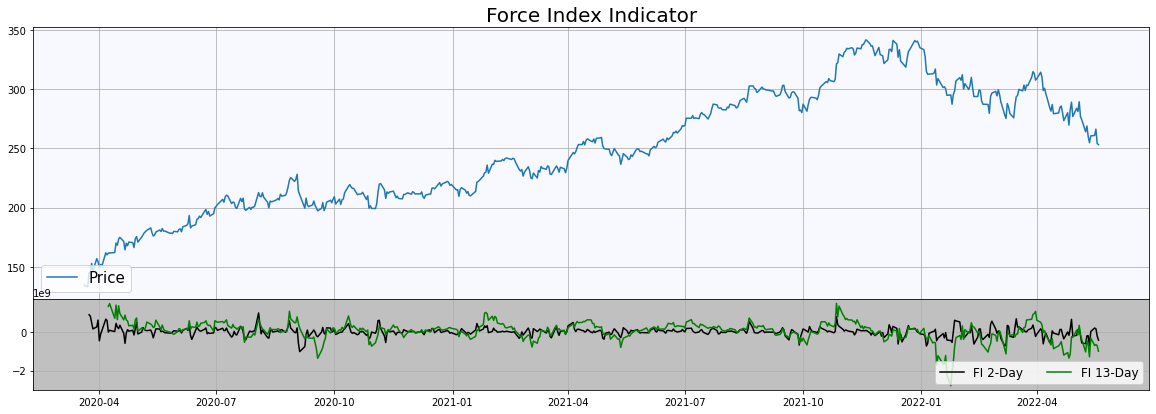

In [29]:
    ###### Plot for Force Index
#     prices_for_fi = get_data_price_volume ('JPM', dates)
    prices_for_fi =stock_price_volume(syms, sd, ed)
    #print(prices_for_fi)
    fi_13 = ForceIndex(prices_for_fi, 13)
    fi_2 = ForceIndex(prices_for_fi, 2)
    #print(fi_13)
    fig5 = plt.figure(facecolor='white', figsize=(20, 10))
    #ax = fig.add_subplot(2,1,1)
    ax = plt.subplot2grid((6, 4), (1, 0), rowspan=3, colspan=4)
    plt.plot(prices_for_fi['Adj Close'])
    plt.grid()

    ax.set_facecolor('ghostwhite')
    ax.legend(['Price'], ncol=2, loc='lower left', fontsize=15)
    plt.title('Force Index Indicator', fontsize=20)
    #bx = fig.add_subplot(2, 1, 2)

    bx = plt.subplot2grid((6, 4), (4, 0), rowspan=1, colspan=4, sharex=ax)
    plt.plot(fi_2, color="black")
    plt.plot(fi_13 , color="green")

    plt.legend(['FI 2-Day','FI 13-Day'],ncol=3, loc = 'lower right', fontsize = 12)
    bx.set_facecolor('silver')
    plt.subplots_adjust( hspace=0)
    plt.grid()


    plt.savefig("Indicator - Force Index")

<p> The aBove figure shows “MSFT” normalized price alongside with Force Index indicators for 2-Day and 13-Day intervals.</p>
<p> As a role of thumb, traders will want to buy when the two-day EMA of force index is negative and sell when it is positive. The 13-day EMA of force index is a longer-term indicator, and, when it crosses above the centerline, the buyers are exerting the greatest force. When it is negative, the sellers have control of the market. If any divergences be-tween a 13-day EMA of force index and prices are observed, that may indicate significant turning points of the market.</p>
<p>&emsp;&emsp; <b>Buy Signal:</b> In an uptrend market, once two-day Force Index drops below zero, that trigger the buying signal</p>
<p>&emsp;&emsp; <b>Sell Signal:</b> In a Downtrend market, as soon as two-day Force Index go above zero, that invoke the sell signal.</p>

<h3>REFERENCES:</h3>
<ol>
    <li>http://www.mrao.cam.ac.uk/~mph/Technical_Analysis.pdf</li>
    <li>https://www.investopedia.com/terms/t/technicalanalysis.asp</li>
    <li>https://www.fidelity.com/learning-center/trading-investing/technical-analy-sis/technical-indicator-guide/bollinger-bands</li>
    <li>https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends</li>
    <li>https://www.investopedia.com/terms/e/ema.asp</li>
    <li>https://thesecretmindset.com/momentum-indicator</li>
    <li>https://www.investopedia.com/terms/r/rsi.asp</li>
    <li>https://school.stockcharts.com/doku.php?id=technical_indicators:force_in-dex</li>
    <li>https://www.profitaddaweb.com/2017/03/force-index-technical-indicators-in.html</li>
    <li>https://www.investopedia.com/articles/trading/03/031203.asp</li>
    </ol>